In [3]:
import pandas as pd
import os
from tqdm.notebook import tqdm
from skimage.transform import resize
from skimage.io import imread
from skimage.feature import hog
from skimage import exposure
import skimage.feature as feature
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [4]:
Categories=['Black_measeles','Healthy','Leaf_Blight','Rot']
flat_data_arr=[] #input array
target_arr=[] #output array
datadir='/kaggle/input/grapessegmented/segmented'
#path which contains all the categories of images
for i in tqdm(Categories):
    
    print(f'loading... category : {i}')
    path=os.path.join(datadir,i)
    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        hsv_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2HSV)
        #gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
        #histg = cv2.calcHist([hsv_img],[0],None,[256],[0,256])
        h_hist = cv2.calcHist([hsv_img], [0], None, [256], [0, 256]).flatten()
        s_hist = cv2.calcHist([hsv_img], [1], None, [256], [0, 256]).flatten()
        v_hist = cv2.calcHist([hsv_img], [2], None, [256], [0, 256]).flatten()
    
        hist_feature = np.concatenate([h_hist, s_hist, v_hist])
        flat_data_arr.append(hist_feature)      
        #flat_data_arr.append(histg.flatten())
        target_arr.append(Categories.index(i))
    print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data) #dataframe
df['Target']=target
 

  0%|          | 0/4 [00:00<?, ?it/s]

loading... category : Black_measeles
loaded category:Black_measeles successfully
loading... category : Healthy
loaded category:Healthy successfully
loading... category : Leaf_Blight
loaded category:Leaf_Blight successfully
loading... category : Rot
loaded category:Rot successfully


In [5]:
df['disease_name'] =df.Target.apply(lambda x: Categories[x])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,Target,disease_name
0,34768.0,26.0,121.0,382.0,112.0,459.0,342.0,209.0,289.0,211.0,...,0.0,0.0,4.0,2.0,2.0,2.0,0.0,16.0,0,Black_measeles
1,25237.0,11.0,23.0,277.0,17.0,170.0,154.0,36.0,132.0,55.0,...,8.0,2.0,1.0,9.0,2.0,4.0,1.0,36.0,0,Black_measeles
2,24979.0,108.0,183.0,1033.0,307.0,1204.0,522.0,350.0,552.0,386.0,...,4.0,5.0,5.0,0.0,0.0,3.0,5.0,14.0,0,Black_measeles
3,38181.0,37.0,2551.0,344.0,107.0,1992.0,129.0,63.0,145.0,134.0,...,3.0,9.0,5.0,5.0,2.0,4.0,2.0,37.0,0,Black_measeles
4,35610.0,43.0,485.0,438.0,174.0,1291.0,251.0,191.0,341.0,199.0,...,1.0,0.0,1.0,2.0,5.0,3.0,1.0,23.0,0,Black_measeles


In [6]:
x= df.drop(['Target','disease_name'], axis='columns')
y = df.Target
y1= df.disease_name

In [7]:
y1

0       Black_measeles
1       Black_measeles
2       Black_measeles
3       Black_measeles
4       Black_measeles
             ...      
2826               Rot
2827               Rot
2828               Rot
2829               Rot
2830               Rot
Name: disease_name, Length: 2831, dtype: object

In [8]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=0)


In [9]:
model_params = {
    'svm': {
        'model': svm.SVC(probability=True),
        'params' : {
            'svc__gamma': [0.0001,0.001,0.01,0.1,1],
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear','poly']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10,20,30,40,50]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(multi_class='auto'),
        'params': {
            'logisticregression__solver':['liblinear'],
            'logisticregression__C': [1,5,10]
        }
    }
}

In [10]:
from sklearn.pipeline import make_pipeline
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in tqdm(model_params.items()):
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(x_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

  0%|          | 0/3 [00:00<?, ?it/s]

,model,best_score,best_params
0,svm,0.965108,"{'svc__C': 1000, 'svc__gamma': 0.0001, 'svc__k..."
1,random_forest,0.962461,{'randomforestclassifier__n_estimators': 50}
2,logistic_regression,0.955832,"{'logisticregression__C': 5, 'logisticregressi..."


In [12]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=1000, gamma=0.0001, probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=50))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=5, solver='liblinear'))])}

In [13]:
if 'svm' in df['model'].values:
    svm_params = df.loc[df['model'] == 'svm', 'best_params'].values[0]
    svm_kernel = svm_params.get('svc__kernel')
    print(f"The best kernel for SVM is: {svm_kernel}")


The best kernel for SVM is: rbf


In [14]:
best_estimators['svm'].score(x_test,y_test)

0.9735449735449735

In [15]:
best_estimators['random_forest'].score(x_test,y_test)

0.9805996472663139

In [16]:
best_estimators['logistic_regression'].score(x_test,y_test)

0.9611992945326279

In [17]:
best_clf = best_estimators['random_forest']

In [18]:
from sklearn.metrics import accuracy_score
y_pred=best_clf.predict(x_test)
print("The predicted Data is :")
print(y_pred)
print("The actual data is:")
print(np.array(y_test))
print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")

The predicted Data is :
[1 2 1 2 1 3 1 1 0 0 1 0 1 0 1 3 1 3 1 0 0 1 0 3 2 1 0 1 3 3 2 0 3 3 2 3 2
 3 0 0 0 3 2 1 1 2 1 0 1 1 2 3 1 3 2 2 2 0 0 0 0 0 0 3 2 2 0 1 0 1 1 0 3 1
 2 2 0 2 1 2 0 2 0 1 0 1 3 0 1 0 3 3 3 3 2 0 3 0 1 2 3 3 0 1 3 2 2 2 2 2 1
 2 2 0 1 1 2 3 0 1 2 3 1 0 0 1 3 2 1 1 0 0 0 3 3 2 0 1 1 0 3 1 3 2 3 3 1 2
 1 2 0 2 2 0 3 3 1 0 2 1 2 0 0 3 3 1 3 1 2 3 2 2 1 1 3 2 2 0 1 0 1 1 0 1 0
 0 2 0 2 0 2 0 2 2 2 2 1 2 3 0 1 1 3 2 1 3 3 1 1 0 1 2 3 0 2 0 3 1 0 3 0 3
 2 3 0 3 3 0 2 3 1 0 1 3 0 2 1 1 1 0 2 1 0 2 2 0 0 3 3 3 3 0 1 1 3 3 0 3 3
 2 3 3 0 2 0 3 0 0 3 3 3 1 0 3 1 1 0 2 2 3 0 3 3 1 0 2 3 3 2 2 1 3 3 0 3 1
 3 3 2 3 3 2 0 3 1 2 1 1 3 1 3 3 2 2 1 3 2 1 1 2 2 0 1 3 1 0 1 3 3 1 0 3 0
 1 2 1 2 1 2 1 2 2 2 2 2 0 3 3 3 1 3 1 2 1 3 1 3 2 1 0 3 0 2 2 1 0 0 0 3 2
 0 0 3 1 0 3 1 0 2 3 3 0 0 1 1 1 0 2 0 2 2 0 2 1 2 0 2 3 3 2 3 2 0 2 3 0 2
 0 2 0 1 0 2 2 0 3 1 2 3 3 1 0 0 1 0 0 0 3 1 2 0 0 0 3 3 1 1 1 2 0 3 2 2 3
 2 0 0 0 0 2 3 3 2 0 2 2 2 2 3 3 2 2 2 0 0 2 3 2 3 2 1 2 1 3 0 0 3 0 2 1 2
 

Text(70.72222222222221, 0.5, 'Truth')

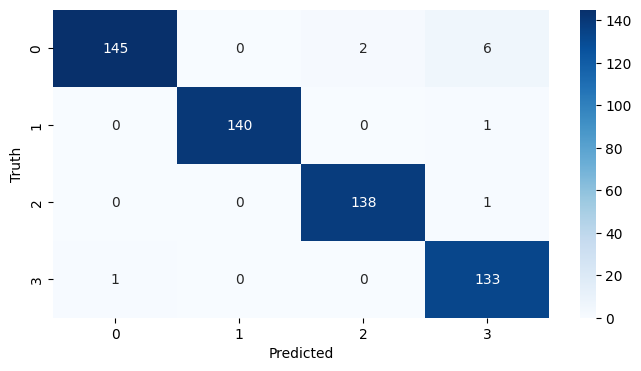

In [20]:
import seaborn as sn
plt.figure(figsize = (8,4))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       153
           1       1.00      0.99      1.00       141
           2       0.99      0.99      0.99       139
           3       0.94      0.99      0.97       134

    accuracy                           0.98       567
   macro avg       0.98      0.98      0.98       567
weighted avg       0.98      0.98      0.98       567



  0%|          | 0/4 [00:00<?, ?it/s]

Processing category: Black_measeles


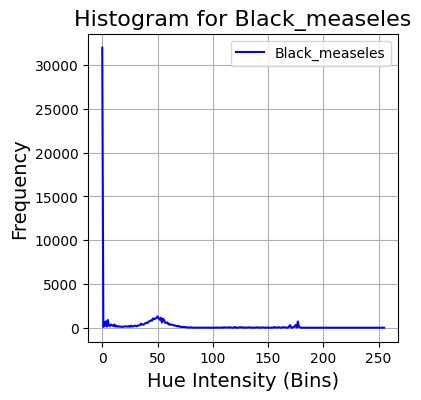

Processing category: Healthy


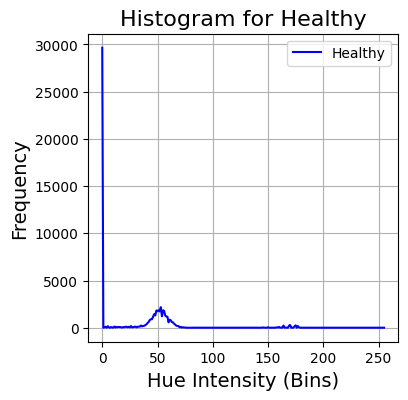

Processing category: Leaf_Blight


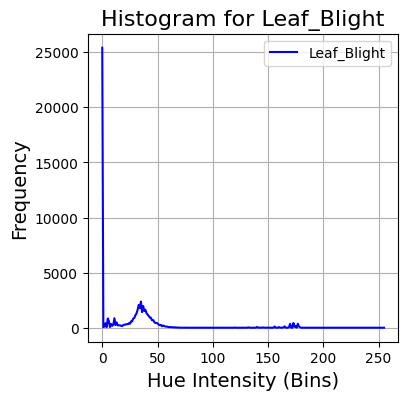

Processing category: Rot


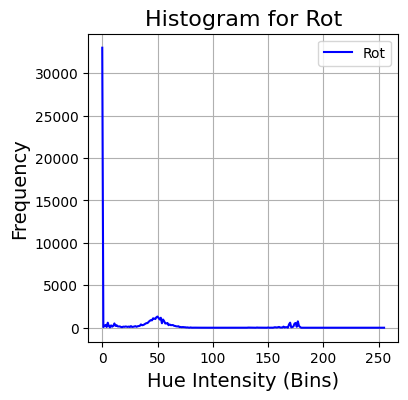


Category Statistics:

Category: Black_measeles
  Average Mean Intensity: 27.09
  Average Variance: 1394.09
  Dominant Hue (Most Common Peak): 0.00

Category: Healthy
  Average Mean Intensity: 30.63
  Average Variance: 1069.10
  Dominant Hue (Most Common Peak): 0.00

Category: Leaf_Blight
  Average Mean Intensity: 24.78
  Average Variance: 1001.58
  Dominant Hue (Most Common Peak): 0.00

Category: Rot
  Average Mean Intensity: 29.86
  Average Variance: 1737.94
  Dominant Hue (Most Common Peak): 0.00


In [22]:
# Function to calculate histogram and extract statistics
def calculate_histogram_and_stats(image):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  # Convert to HSV
    hist = cv2.calcHist([hsv_img], [0], None, [256], [0, 256])  # Hue channel histogram
    hist = hist.flatten()
    
    # Calculate statistics
    total_pixels = np.sum(hist)
    normalized_hist = hist / total_pixels  # Normalize to get probability distribution
    mean_intensity = np.sum(normalized_hist * np.arange(256))  # Weighted mean
    variance = np.sum(normalized_hist * (np.arange(256) - mean_intensity) ** 2)  # Variance
    dominant_peak = np.argmax(hist)  # Bin with the maximum intensity
    
    return hist, mean_intensity, variance, dominant_peak

# Dictionary to store category statistics
category_stats = {}

# Loop through categories
for category in tqdm(Categories):
    print(f'Processing category: {category}')
    category_path = os.path.join(datadir, category)
    histograms = []
    mean_values = []
    variances = []
    dominant_peaks = []
    
    # Loop through each image in the category
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = imread(img_path)
        
        # Calculate histogram and stats
        hist, mean_intensity, variance, dominant_peak = calculate_histogram_and_stats(img)
        histograms.append(hist)
        mean_values.append(mean_intensity)
        variances.append(variance)
        dominant_peaks.append(dominant_peak)
    
    # Aggregate statistics for the category
    avg_histogram = np.mean(histograms, axis=0)
    avg_mean = np.mean(mean_values)
    avg_variance = np.mean(variances)
    most_common_peak = np.bincount(dominant_peaks).argmax()  # Most frequent peak
    
    category_stats[category] = {
        "Average Mean Intensity": avg_mean,
        "Average Variance": avg_variance,
        "Dominant Hue (Most Common Peak)": most_common_peak
    }
    
    # Plot average histogram
    plt.figure(figsize=(4, 4))
    plt.title(f"Histogram for {category}", fontsize=16)
    plt.plot(avg_histogram, color='blue', label=f'{category}')
    plt.xlabel("Hue Intensity (Bins)", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

# Display category statistics
print("\nCategory Statistics:")
for category, stats in category_stats.items():
    print(f"\nCategory: {category}")
    for stat, value in stats.items():
        print(f"  {stat}: {value:.2f}")
